# Detekcija emocija korišćenjem EfficientNet B7

---------

In [1]:
import requests
from zipfile import ZipFile
from pathlib import Path

import os
import glob

import random as random
from PIL import Image

import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchvision
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from torchvision import datasets
from torchvision import transforms

import torchmetrics
import mlxtend

import matplotlib.pyplot as plt

from typing import Tuple
from typing import Dict
from typing import List
from timeit import default_timer as timer
from matplotlib import patches as mpatches

from tqdm.auto import tqdm

import gc

from numba import cuda

from GPUtil import showUtilization as gpu_usage

# import splitfolders

from torchinfo import summary

import shutil

import numpy as np
import pandas as pd
# import yaml

from os import listdir                  
from os.path import isfile, join

c:\Users\Nevena\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

## 1. Učitavanje podataka

### 1.1 Postavljanje putanje

In [3]:
data_path = Path("Kaggle/CV/Emotions_detection")
zipfile_path = data_path / "archive.zip"
images_path = data_path / "emotions_dataset"

Kaggle\CV\Emotions_detection\emotions_dataset exists.
Data already extracted.


In [4]:
def walk_through_dir(dir_path: Path) -> None:
    """Prints dir_path content"""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directiories and {len(filenames)} images in '{dirpath}' folder ")


walk_through_dir(images_path)

There are 2 directiories and 0 images in 'Kaggle\CV\Emotions_detection\emotions_dataset' folder 
There are 7 directiories and 0 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\test' folder 
There are 0 directiories and 958 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\test\angry' folder 
There are 0 directiories and 111 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\test\disgusted' folder 
There are 0 directiories and 1024 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\test\fearful' folder 
There are 0 directiories and 1774 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\test\happy' folder 
There are 0 directiories and 1233 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\test\neutral' folder 
There are 0 directiories and 1247 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\test\sad' folder 
There are 0 directiories and 831 images in 'Kaggle\CV\Emotions_detection\emotions_dataset\test\surprised' folder 
There are 7 direc

### 1.2. Transformacije za dataloadere

In [5]:
train_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)),
     transforms.ToTensor()]
)

val_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)),
     transforms.ToTensor()]
)

### 1.3. Učitavanje podataka

In [6]:
train_dir = images_path / "train"
val_dir = images_path / "test"

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

val_data = datasets.ImageFolder(
    root=val_dir,
    transform=val_transform
)

### 1.4. Dataloader-i

In [7]:
BATCH_SIZE = 8

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

## 2. Model

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 2.1 Učitavanje modela

In [9]:
BATCH_SIZE = 16
model = torchvision.models.efficientnet_b7().to(device)


summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 1000]           --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 2560, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 64, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 64, 112, 112]   1,728                True
│    │    └─BatchNorm2d (1)                                  [16, 64, 112, 112]   [16, 64, 112, 112]   128                  True
│    │    └─SiLU (2)                                         [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 64, 112, 112]   [16, 32, 112

## 2.2 Definisanje klasifikatora

In [10]:
output_shape = len(train_data.classes)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2560, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

summary(
    model=model,
    input_size=(BATCH_SIZE, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [16, 3, 224, 224]    [16, 7]              --                   True
├─Sequential (features)                                      [16, 3, 224, 224]    [16, 2560, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 64, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 64, 112, 112]   1,728                True
│    │    └─BatchNorm2d (1)                                  [16, 64, 112, 112]   [16, 64, 112, 112]   128                  True
│    │    └─SiLU (2)                                         [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
│    └─Sequential (1)                                        [16, 64, 112, 112]   [16, 32, 112

## 2. Treniranje


In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device) -> Tuple[float, float, torch.Tensor]:

    model.eval()
    val_loss, val_acc = 0, 0
    y_preds = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = torch.argmax(val_pred_logits, dim=1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))
            y_preds.append(val_pred_labels.cpu())

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    y_pred_tensor = torch.cat(y_preds)

    return val_loss, val_acc, y_pred_tensor


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device) -> Tuple[Dict, torch.Tensor]:

    results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "val_acc": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        val_loss, val_acc, y_preds = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train acc: {train_acc:.3f}, Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results, y_preds

## RUN

In [12]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.01
)

start_time = timer()

model_results, preds = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device
)

end_time = timer()
print(f"Total learning time: {(end_time - start_time):.3f}")

  5%|▌         | 1/20 [12:31<3:58:00, 751.59s/it]

Epoch: 0, Train loss: 1.880, Train acc: 0.214, Val loss: 63.744, Val acc: 0.144


 10%|█         | 2/20 [24:55<3:44:09, 747.17s/it]

Epoch: 1, Train loss: 1.865, Train acc: 0.218, Val loss: 1.926, Val acc: 0.247


 15%|█▌        | 3/20 [37:20<3:31:22, 746.06s/it]

Epoch: 2, Train loss: 1.868, Train acc: 0.215, Val loss: 1.833, Val acc: 0.210


 20%|██        | 4/20 [50:39<3:24:35, 767.19s/it]

Epoch: 3, Train loss: 1.868, Train acc: 0.216, Val loss: 1.866, Val acc: 0.247


 25%|██▌       | 5/20 [1:04:24<3:16:59, 787.99s/it]

Epoch: 4, Train loss: 1.854, Train acc: 0.218, Val loss: 1.924, Val acc: 0.247


 30%|███       | 6/20 [1:18:04<3:06:20, 798.59s/it]

Epoch: 5, Train loss: 1.738, Train acc: 0.300, Val loss: 1.628, Val acc: 0.349


 35%|███▌      | 7/20 [1:31:44<2:54:33, 805.67s/it]

Epoch: 6, Train loss: 1.580, Train acc: 0.377, Val loss: 1.508, Val acc: 0.405


 40%|████      | 8/20 [1:45:23<2:42:01, 810.13s/it]

Epoch: 7, Train loss: 1.487, Train acc: 0.414, Val loss: 1.495, Val acc: 0.443


 45%|████▌     | 9/20 [1:59:05<2:29:09, 813.55s/it]

Epoch: 8, Train loss: 1.421, Train acc: 0.449, Val loss: 1.427, Val acc: 0.447


 50%|█████     | 10/20 [2:12:46<2:16:00, 816.03s/it]

Epoch: 9, Train loss: 1.379, Train acc: 0.465, Val loss: 1.386, Val acc: 0.453


 55%|█████▌    | 11/20 [2:26:26<2:02:35, 817.24s/it]

Epoch: 10, Train loss: 1.338, Train acc: 0.484, Val loss: 1.253, Val acc: 0.517


 60%|██████    | 12/20 [2:40:06<1:49:04, 818.07s/it]

Epoch: 11, Train loss: 1.303, Train acc: 0.498, Val loss: 1.323, Val acc: 0.491


 65%|██████▌   | 13/20 [2:53:46<1:35:29, 818.53s/it]

Epoch: 12, Train loss: 1.267, Train acc: 0.515, Val loss: 1.295, Val acc: 0.510


 70%|███████   | 14/20 [3:07:16<1:21:36, 816.05s/it]

Epoch: 13, Train loss: 1.234, Train acc: 0.531, Val loss: 1.214, Val acc: 0.544


 75%|███████▌  | 15/20 [3:20:57<1:08:07, 817.58s/it]

Epoch: 14, Train loss: 1.195, Train acc: 0.545, Val loss: 1.222, Val acc: 0.557


 80%|████████  | 16/20 [3:34:40<54:37, 819.32s/it]  

Epoch: 15, Train loss: 1.168, Train acc: 0.563, Val loss: 1.212, Val acc: 0.564


 85%|████████▌ | 17/20 [3:48:22<41:00, 820.09s/it]

Epoch: 16, Train loss: 1.145, Train acc: 0.574, Val loss: 1.175, Val acc: 0.568


 90%|█████████ | 18/20 [4:02:03<27:20, 820.22s/it]

Epoch: 17, Train loss: 1.117, Train acc: 0.581, Val loss: 1.213, Val acc: 0.546


 95%|█████████▌| 19/20 [4:15:42<13:39, 819.78s/it]

Epoch: 18, Train loss: 1.097, Train acc: 0.591, Val loss: 1.145, Val acc: 0.565


100%|██████████| 20/20 [4:29:22<00:00, 808.15s/it]

Epoch: 19, Train loss: 1.071, Train acc: 0.599, Val loss: 1.178, Val acc: 0.570
Total learning time: 16174.028


## 3. Vizuelizacija

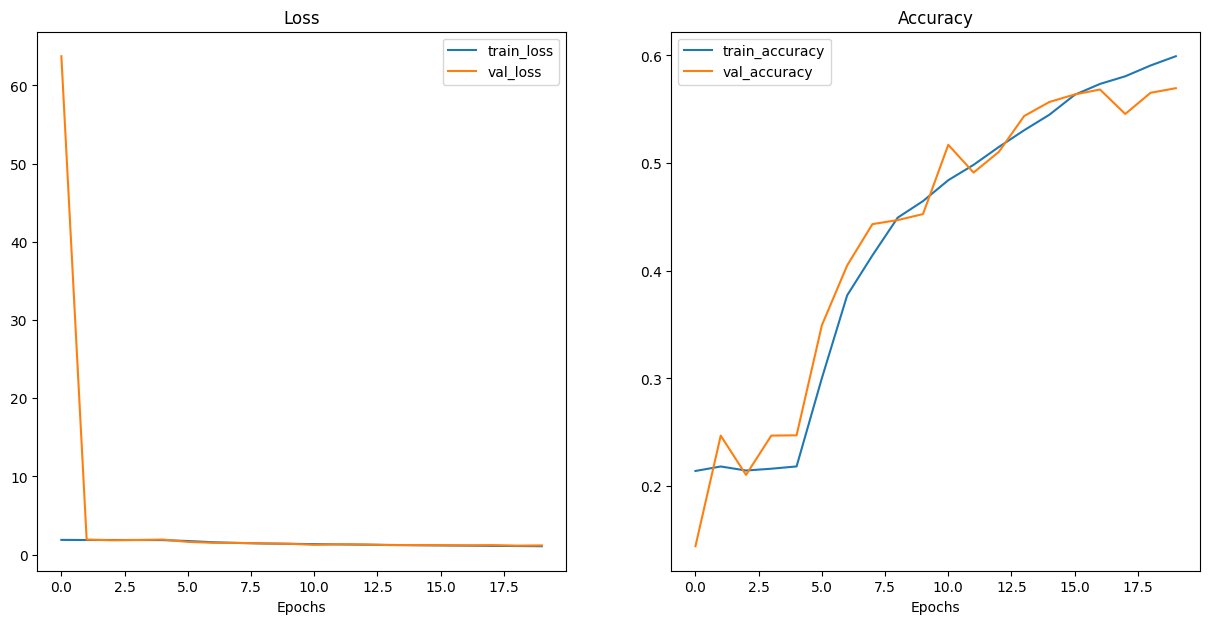

In [13]:
def plot_curves(results: Dict[str, List[float]]) -> None:
    """Plots loss and accuracy from a results dictionary."""

    train_loss = results["train_loss"]
    val_loss = results["val_loss"]

    train_accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


plot_curves(model_results)

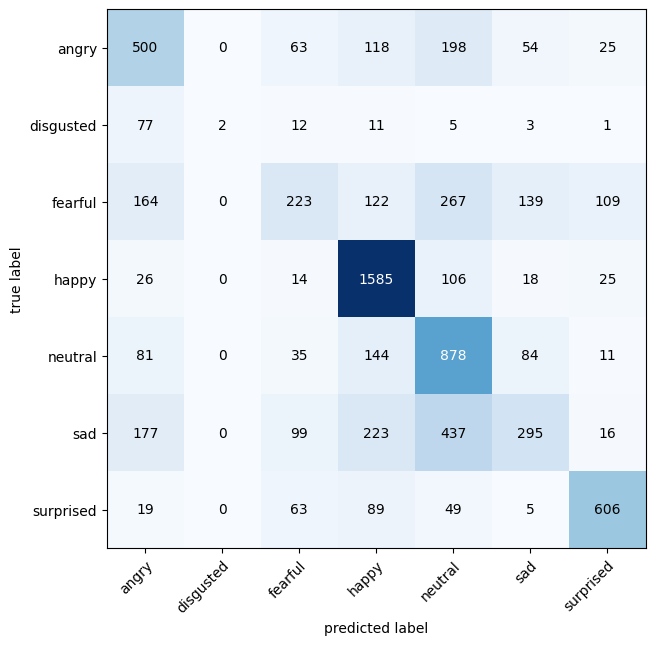

In [14]:
def draw_confusion_matrix(data: datasets.ImageFolder,
                          preds: torch.Tensor) -> None:

    confmat = ConfusionMatrix(num_classes=len(data.classes),task='multiclass')
    confmat_tensor = confmat(
        preds=preds,
        target=torch.ShortTensor(val_data.targets)
    )

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=data.classes,
        figsize=(10, 7))


draw_confusion_matrix(data=val_data,
                      preds=preds)

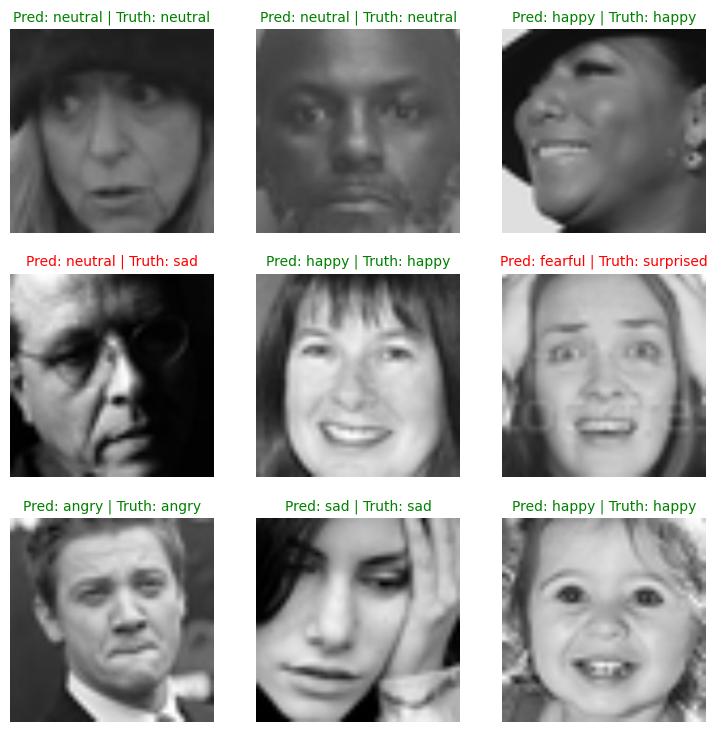

In [15]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device) -> torch.Tensor:

    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)


def show_predictions(model: torch.nn.Module,
                     device: torch.device,
                     val_data: datasets) -> None:

    val_samples = []
    val_labels = []

    for sample, label in random.sample(list(val_data), k=9):
        val_samples.append(sample)
        val_labels.append(label)

    pred_probs = make_predictions(
        model=model,
        data=val_samples,
        device=device
    )

    pred_classes = pred_probs.argmax(dim=1)
    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3

    for i, sample in enumerate(val_samples):
        plt.subplot(nrows, ncols, i+1)
        image = sample.squeeze().permute(1, 2, 0)
        plt.imshow(image)
        pred_label = val_data.classes[pred_classes[i]]
        truth_label = val_data.classes[val_labels[i]]
        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, c="g")
        else:
            plt.title(title_text, fontsize=10, c="r")
        plt.axis(False)


show_predictions(
    model=model,
    val_data=val_data,
    device=device)